In [1]:
from datetime import datetime
import numpy as np
import bw2data as bd
from bw_temporalis import TemporalDistribution
from optimex import lca_processor

# Set the project (creates it if not existing)
bd.projects.set_current("basic_usage_example")

# BIOSPHERE
biosphere_data = {
    ("biosphere3", "CO2"): {
        "type": "emission",
        "name": "carbon dioxide",
        "CAS number": "000124-38-9"
    },
    ("biosphere3", "CH4"): {
        "type": "emission",
        "name": "methane, fossil",
        "CAS number": "000074-82-8"
    },
}
bd.Database("biosphere3").write(biosphere_data)

# BACKGROUND 2020
db_2020_data = {
    ("db_2020", "I1"): {
        "name": "node I1",
        "location": "somewhere",
        "reference product": "I1",
        "exchanges": [
            {"amount": 1, "type": "production", "input": ("db_2020", "I1")},
            {"amount": 1, "type": "biosphere", "input": ("biosphere3", "CO2")},
        ],
    },
    ("db_2020", "I2"): {
        "name": "node I2",
        "location": "somewhere",
        "reference product": "I2",
        "exchanges": [
            {"amount": 1, "type": "production", "input": ("db_2020", "I2")},
            {"amount": 1, "type": "biosphere", "input": ("biosphere3", "CH4")},
        ],
    },
}
bg_2020 = bd.Database("db_2020")
bg_2020.write(db_2020_data)
bg_2020.metadata["representative_time"] = datetime(2020, 1, 1).isoformat()
bg_2020.register()

# BACKGROUND 2030
db_2030_data = {
    ("db_2030", "I1"): {
        "name": "node I1",
        "location": "somewhere",
        "reference product": "I1",
        "exchanges": [
            {"amount": 1, "type": "production", "input": ("db_2030", "I1")},
            {"amount": 0.9, "type": "biosphere", "input": ("biosphere3", "CO2")},
        ],
    },
    ("db_2030", "I2"): {
        "name": "node I2",
        "location": "somewhere",
        "reference product": "I2",
        "exchanges": [
            {"amount": 1, "type": "production", "input": ("db_2030", "I2")},
            {"amount": 0.9, "type": "biosphere", "input": ("biosphere3", "CH4")},
        ],
    },
}
bg_2030 = bd.Database("db_2030")
bg_2030.write(db_2030_data)
bg_2030.metadata["representative_time"] = datetime(2030, 1, 1).isoformat()
bg_2030.register()

# FOREGROUND - temporally distributed
foreground_data = {
    ("foreground", "P1"): {
        "name": "process P1",
        "location": "somewhere",
        "reference product": "F1",
        "operation_time_limits": (1,2), # start and end year of operation phase
        "exchanges": [
            {
                "amount": 1,
                "type": "production",
                "input": ("foreground", "P1"),
                "temporal_distribution": TemporalDistribution(
                    date=np.array(range(4), dtype="timedelta64[Y]"),
                    amount=np.array([0, 0.5, 0.5, 0]),
                ),
                "operation": True,
            },
            {
                "amount": 27.5,
                "type": "technosphere",
                "input": ("db_2020", "I1"),
                "temporal_distribution": TemporalDistribution(
                    date=np.array(range(4), dtype="timedelta64[Y]"),
                    amount=np.array([1, 0, 0, 0]),
                ),
            },
            {
                "amount": 20,
                "type": "biosphere",
                "input": ("biosphere3", "CO2"),
                "temporal_distribution": TemporalDistribution(
                    date=np.array(range(4), dtype="timedelta64[Y]"),
                    amount=np.array([0, 0.5, 0.5, 0]),
                ),
                "operation": True,
            },
        ],
    },
    ("foreground", "P2"): {
        "name": "process P2",
        "location": "somewhere",
        "reference product": "F1",
        "operation_time_limits": (1,2),
        "exchanges": [
            {
                "amount": 1,
                "type": "production",
                "input": ("foreground", "P2"),
                "temporal_distribution": TemporalDistribution(
                    date=np.array(range(4), dtype="timedelta64[Y]"),
                    amount=np.array([0, 0.5, 0.5, 0]),
                ),
                "operation": True,
            },
            {
                "amount": 1,
                "type": "technosphere",
                "input": ("db_2020", "I2"),
                "temporal_distribution": TemporalDistribution(
                    date=np.array(range(4), dtype="timedelta64[Y]"),
                    amount=np.array([1, 0, 0, 0]),
                ),
            },
            {
                "amount": 20,
                "type": "biosphere",
                "input": ("biosphere3", "CO2"),
                "temporal_distribution": TemporalDistribution(
                    date=np.array(range(4), dtype="timedelta64[Y]"),
                    amount=np.array([0, 0.5, 0.5, 0]),
                ),
                "operation": True,
            },
        ],
    },
}
fg = bd.Database("foreground")
fg.write(foreground_data)
fg.register()


bd.Method(("GWP", "example")).write([
    (("biosphere3", "CO2"), 1),
    (("biosphere3", "CH4"), 27),
])

bd.Method(("land use", "example")).write([
    (("biosphere3", "CO2"), 2),
    (("biosphere3", "CH4"), 1),
])

100%|██████████| 2/2 [00:00<?, ?it/s]


17:17:51+0200 [info     ] Vacuuming database            
17:17:51+0200 [warning  ] Not able to determine geocollections for all datasets. This database is not ready for regionalization.


100%|██████████| 2/2 [00:00<?, ?it/s]


17:17:51+0200 [info     ] Vacuuming database            
17:17:51+0200 [warning  ] Not able to determine geocollections for all datasets. This database is not ready for regionalization.


100%|██████████| 2/2 [00:00<?, ?it/s]


17:17:51+0200 [info     ] Vacuuming database            
17:17:51+0200 [warning  ] Not able to determine geocollections for all datasets. This database is not ready for regionalization.


100%|██████████| 2/2 [00:00<?, ?it/s]


17:17:51+0200 [info     ] Vacuuming database            


In [2]:
from optimex import lca_processor


# For optimex to work, we need to manually define which processes  produce desired 
# products labeled as functional flows
foreground = bd.Database("foreground")
for act in foreground:
    act["functional flow"] = "F1"
    act.save()

# Define temporally distributed demand from 2020 to 2030
years = range(2020, 2030)
td_demand = TemporalDistribution(
    date=np.array([datetime(year, 1, 1).isoformat() for year in years], dtype='datetime64[s]'),
    amount=np.asarray([0, 0, 10, 5, 10, 5, 10, 5, 10, 5]),
)

lca_config = lca_processor.LCAConfig(
    demand = {"F1": td_demand},
    temporal= {
        "start_date": datetime(2020, 1, 1),
        "temporal_resolution": "year",
        "timehorizon": 100,
    },
    characterization_methods=[
        {
            "category_name": "climate_change",
            "brightway_method": ("GWP", "example"),
            "metric": "CRF",
        },
        {
            "category_name": "land_use",
            "brightway_method": ("land use", "example"),
        },
    ],
    background_inventory={
        "cutoff": 1e4,
        "calculation_method": "sequential",
    },
)

In [3]:
td_demand.date

array(['2020-01-01T00:00:00', '2021-01-01T00:00:00',
       '2022-01-01T00:00:00', '2023-01-01T00:00:00',
       '2024-01-01T00:00:00', '2025-01-01T00:00:00',
       '2026-01-01T00:00:00', '2027-01-01T00:00:00',
       '2028-01-01T00:00:00', '2029-01-01T00:00:00'],
      dtype='datetime64[s]')

In [4]:
lca_data_processor = lca_processor.LCADataProcessor(lca_config)

2025-05-27 17:17:51.904 | INFO     | optimex.lca_processor:_parse_demand:323 - Identified demand in system time range of %s for functional flows %s
2025-05-27 17:17:51.914 | INFO     | optimex.lca_processor:_construct_foreground_tensors:447 - Constructed foreground tensors.
2025-05-27 17:17:51.917 | INFO     | optimex.lca_processor:log_tensor_dimensions:442 - Technosphere shape: (2 processes, 2 flows, 4 years) with 8 total entries.
2025-05-27 17:17:51.918 | INFO     | optimex.lca_processor:log_tensor_dimensions:442 - Biosphere shape: (2 processes, 1 flows, 4 years) with 8 total entries.
2025-05-27 17:17:51.920 | INFO     | optimex.lca_processor:log_tensor_dimensions:442 - Production shape: (2 processes, 1 flows, 4 years) with 8 total entries.
2025-05-27 17:17:51.922 | INFO     | optimex.lca_processor:_calculate_inventory_of_db:485 - Calculating inventory for database: db_2020
2025-05-27 17:17:52.000 | INFO     | optimex.lca_processor:_calculate_inventory_of_db:501 - Factorized LCI for 

In [5]:
from optimex import converter

manager = converter.ModelInputManager()
model_inputs = manager.parse_from_lca_processor(lca_data_processor)


In [6]:
model_inputs.model_dump()

{'PROCESS': ['P1', 'P2'],
 'FUNCTIONAL_FLOW': ['F1'],
 'INTERMEDIATE_FLOW': ['I1', 'I2'],
 'ELEMENTARY_FLOW': ['CO2', 'CH4'],
 'BACKGROUND_ID': ['db_2020', 'db_2030'],
 'PROCESS_TIME': [0, 1, 2, 3],
 'SYSTEM_TIME': [2020, 2021, 2022, 2023, 2024, 2025, 2026, 2027, 2028, 2029],
 'CATEGORY': ['land_use', 'climate_change'],
 'demand': {('F1', 2020): 0.0,
  ('F1', 2021): 0.0,
  ('F1', 2022): 10.0,
  ('F1', 2023): 5.0,
  ('F1', 2024): 10.0,
  ('F1', 2025): 5.0,
  ('F1', 2026): 10.0,
  ('F1', 2027): 5.0,
  ('F1', 2028): 10.0,
  ('F1', 2029): 5.0},
 'operation_flow': {('P1', 'F1'): True,
  ('P1', 'CO2'): True,
  ('P2', 'F1'): True,
  ('P2', 'CO2'): True},
 'foreground_technosphere': {('P1', 'I1', 0): 27.5,
  ('P1', 'I1', 1): 0.0,
  ('P1', 'I1', 2): 0.0,
  ('P1', 'I1', 3): 0.0,
  ('P2', 'I2', 0): 1.0,
  ('P2', 'I2', 1): 0.0,
  ('P2', 'I2', 2): 0.0,
  ('P2', 'I2', 3): 0.0},
 'foreground_biosphere': {('P1', 'CO2', 0): 0.0,
  ('P1', 'CO2', 1): 10.0,
  ('P1', 'CO2', 2): 10.0,
  ('P1', 'CO2', 3): 0.

In [7]:
from optimex import optimizer

model = optimizer.create_model(
    model_inputs,
    name = "demo_simple_example",
    objective_category= "climate_change",
    flexible_operation= True,
)

2025-05-27 17:17:53.311 | INFO     | optimex.optimizer:create_model:67 - Creating sets
2025-05-27 17:17:53.312 | INFO     | optimex.optimizer:create_model:109 - Creating parameters
2025-05-27 17:17:53.315 | INFO     | optimex.optimizer:create_model:273 - Creating variables


In [8]:
m, obj, results = optimizer.solve_model(model)
obj

Set parameter Username
Academic license - for non-commercial use only - expires 2025-09-10
Read LP format model from file C:\Users\HP\AppData\Local\Temp\tmpuqdrrw79.pyomo.lp
Reading time = 0.00 seconds
x1: 52 rows, 40 columns, 114 nonzeros
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i5-8365U CPU @ 1.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 52 rows, 40 columns and 114 nonzeros
Model fingerprint: 0x4b0ffc45
Coefficient statistics:
  Matrix range     [2e-02, 1e+00]
  Objective range  [1e-02, 4e-02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 4e-01]
Presolve removed 36 rows and 16 columns
Presolve time: 0.00s
Presolved: 16 rows, 24 columns, 46 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.5645935e+00   8.727273e+00   0.000000e+00      0s
       9    4.3308071e+00   0.00

2025-05-27 17:17:53.598 | INFO     | optimex.optimizer:solve_model:585 - Solver [gurobi] termination: optimal
2025-05-27 17:17:53.603 | INFO     | optimex.optimizer:solve_model:610 - Objective (scaled): 4.33081
2025-05-27 17:17:53.607 | INFO     | optimex.optimizer:solve_model:611 - Objective (real):   2.81685e-10


2.8168480053375177e-10

In [ ]:
from optimex import postprocessing

pp = postprocessing.PostProcessor(m)

df_impact = pp.get_impacts()
df_impact

Category     land_use        climate_change              
Process            P1     P2             P1            P2
Time                                                     
2020         0.000000    0.0   0.000000e+00  0.000000e+00
2021         0.000000   19.8   0.000000e+00  4.682937e-11
2022         0.000000  400.0   0.000000e+00  1.743223e-11
2023         0.000000  219.4   0.000000e+00  5.452696e-11
2024         0.000000  400.0   0.000000e+00  1.715036e-11
2025      1044.999987  200.0   4.443576e-11  8.504451e-12
2026       400.000000    0.0   1.686709e-11  0.000000e+00
2027      1222.999982    0.0   5.113645e-11  0.000000e+00
2028       400.000000    0.0   1.658239e-11  0.000000e+00
2029       200.000000    0.0   8.219740e-12  0.000000e+00

In [10]:
df_install = pp.get_installation()
df_operation = pp.get_operation()
df_production = pp.get_production()
df_demand = pp.get_demand()

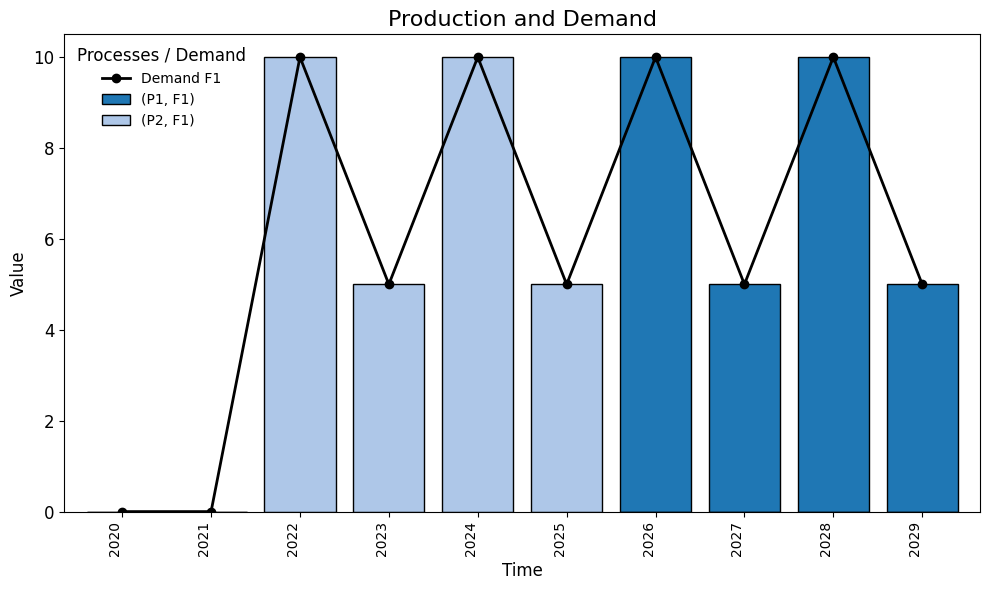

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Production and Demand'}, xlabel='Time', ylabel='Value'>)

In [13]:
pp.plot_production_and_demand()